In [1]:
# Import libraries
import pandas as pd


In [2]:
#Import data
URL_DATASET =r'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covnatdf = pd.read_csv(URL_DATASET)
noOfDatapt = 90
#covnatdf[covnatdf.location=='United Kingdom'].tail(noOfDatapt)
covnatdf=covnatdf[covnatdf.iso_code=="GBR"] #USA,ESP,ITA,KOR,GBR
data_death = covnatdf["total_deaths_per_million"].tail(noOfDatapt)
data_infection = covnatdf["total_cases_per_million"].tail(noOfDatapt)
Ppl = 1000000
data_death

7001      0.000
7002      0.000
7003      0.000
7004      0.000
7005      0.015
7006      0.029
7007      0.029
7008      0.044
7009      0.103
7010      0.103
7011      0.133
7012      0.147
7013      0.412
7014      0.633
7015      0.957
7016      1.193
7017      1.694
7018      2.327
7019      2.858
7020      3.683
7021      4.198
7022      5.288
7023      7.483
7024     10.223
7025     12.919
7026     17.102
7027     21.433
7028     24.585
7029     30.095
7030     35.722
         ...   
7061    405.238
7062    414.386
7063    419.026
7064    423.268
7065    433.477
7066    443.037
7067    450.977
7068    460.198
7069    465.295
7070    469.243
7071    472.336
7072    481.572
7073    488.849
7074    495.154
7075    500.810
7076    507.704
7077    510.208
7078    512.565
7079    520.593
7080    525.941
7081    530.919
7082    536.090
7083    540.244
7084    541.982
7085    543.765
7086    545.738
7087    551.807
7088    557.361
7089    562.134
7090    565.301
Name: total_deaths_per_m

## Model creation

In [3]:
def deriv(y,t,N10,alpha,beta,c,lmbda,mu,p_d,p_grp,p_r,p_s,sigma):
    S[0],S[1],E[0],E[1],I,R,D=y
    dS1dt = (p_grp * p_s * (lmbda - mu)) - (beta * c * alpha * S[0] *(alpha * (E[0] + I) + E[1]))/Ppl                        
    ds2dt = ((1-p_grp) * p_s * (lmbda - mu)) - (beta * c * S[1] *(alpha * (E[0] + I) + E[1]))/Ppl                        
    de1dt = (p_grp * (1 - p_s) * (lmbda - mu)) + (beta * c * alpha * S[0] *(alpha * (E[0] + I) + E[1]))/Ppl + (N10 * E[1]) - (sigma * E[0])                       
    de2dt = ((1-p_grp) * (1 - p_s) * (lmbda - mu)) + (beta * c * S[1] *(alpha * (E[0] + I) + E[1]))/Ppl - ((N10 + sigma) * E[1])
    didt = (sigma *(E[0] + E[1])) - (p_r + p_d) * I 
    dddt = p_d * I
    drdt = p_r * I
    return dS1dt, ds2dt, de1dt,de2dt,didt,dddt,drdt


In [4]:
from lmfit import Parameters

S = [Ppl/2,Ppl/2]       #Group1 use preventive measures, group2 doesn't
E = [0,0]
I = 1                   #number of infected people.
D = 0                   #number of death.
R = 0                   #number of recovery
initCond = (S[0],S[1],E[0],E[1],I,R,D)

#Parameters
pfit = Parameters()
#Rate of people in group i. Either person takes precaution or not
pfit.add(name='p_grp', value=0.6, min=0, max=1)
#Rate of: people is normal.
pfit.add(name='p_s', value=0.7,min=0, max=1)
#Population inflow
pfit.add(name='lmbda', value=2000,min=0, max=Ppl)
# Population outflow.
pfit.add(name='mu', value=1000,min=0, max=Ppl)
#Average risk per infected contact (R_0)
pfit.add(name='beta', value=1.5,min=0, max=4)
#Average contacts per person per day (function of policies & time) (<1 means no spread of disease)
pfit.add(name='c', value=1.1,min=0, max=20)
#Incubation rate, at which infected people develops symptoms.
pfit.add(name='sigma', value=0.14,min=0.14, max=0.25)
#Per capita rate of migration of infected ones from group i to j.
pfit.add(name='N10', value=0.5,min=0, max=1)
#The rate of death.
pfit.add(name='p_d', value=0.0001,min=0, max=1)
#The rate of recovery.
pfit.add(name='p_r', value=0.0002,min=0, max=1)
#Descrease rate of indivisual catching virus
pfit.add(name='alpha', value=0.1, min=0, max=1)

pfit.pretty_print()


Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
N10         0.5        0        1     None     True     None     None
alpha       0.1        0        1     None     True     None     None
beta        1.5        0        4     None     True     None     None
c           1.1        0       20     None     True     None     None
lmbda      2000        0    1e+06     None     True     None     None
mu         1000        0    1e+06     None     True     None     None
p_d      0.0001        0        1     None     True     None     None
p_grp       0.6        0        1     None     True     None     None
p_r      0.0002        0        1     None     True     None     None
p_s         0.7        0        1     None     True     None     None
sigma      0.14     0.14     0.25     None     True     None     None


In [5]:
def iModSol(t,N10,alpha,beta,c,lmbda,mu,p_d,p_grp,p_r,p_s,sigma,initCondn):
    y0 = initCondn
    ret = odeint(deriv, y0, t,args=(N10,alpha,beta,c,lmbda,mu,p_d,p_grp,p_r,p_s,sigma))
    return ret.T

def Model_fitter(t,N10,alpha,beta,c,lmbda,mu,p_d,p_grp,p_r,p_s,sigma):
    ret = iModSol(t,N10,alpha,beta,c,lmbda,mu,p_d,p_grp,p_r,p_s,sigma,initCond)
    return ret[5]

def Model_pred(t,N10,alpha,beta,c,lmbda,mu,p_d,p_grp,p_r,p_s,sigma):
    ret = iModSol(t,N10,alpha,beta,c,lmbda,mu,p_d,p_grp,p_r,p_s,sigma,initCond)
    return ret

In [6]:
import numpy as np
from scipy.integrate import odeint

t = np.linspace(0, noOfDatapt-1, noOfDatapt) # Grid of time points (in days)

In [15]:
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from lmfit import Model


fitted_model = Model(Model_fitter)
params = fitted_model.make_params()
params = pfit


result = fitted_model.fit(data_death,params, t=t,method='leastsq')
print(result.fit_report())



[[Model]]
    Model(Model_fitter)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 281
    # data points      = 90
    # variables        = 11
    chi-square         = 387.754325
    reduced chi-square = 4.90828260
    Akaike info crit   = 153.450606
    Bayesian info crit = 180.948512
##  Warning: uncertainties could not be estimated:
    sigma:  at initial value
    sigma:  at boundary
[[Variables]]
    p_grp:  0.80723111 (init = 0.6)
    p_s:    0.88216451 (init = 0.7)
    lmbda:  935.644408 (init = 2000)
    mu:     723.212325 (init = 1000)
    beta:   3.09265879 (init = 1.5)
    c:      0.81882760 (init = 1.1)
    sigma:  0.14000000 (init = 0.14)
    N10:    0.79331215 (init = 0.5)
    p_d:    1.0253e-04 (init = 0.0001)
    p_r:    0.03914754 (init = 0.0002)
    alpha:  2.4137e-04 (init = 0.1)


In [9]:
# Making prediction based on fitted parameters
fparams = result.params.valuesdict()


fit_model = Model_pred(t,fparams['N10'],fparams['alpha'],
                       fparams['beta'],fparams['c'],fparams['lmbda'],
                       fparams['mu'],fparams['p_d'],fparams['p_grp'],
                       fparams['p_r'],fparams['p_s'],fparams['sigma'])



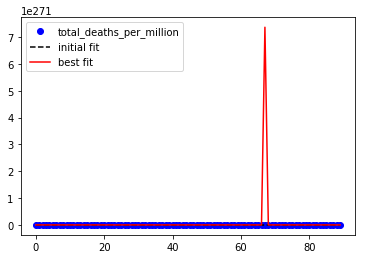

In [12]:
import matplotlib.pyplot as plt

plt.plot(t, data_death, 'bo')
plt.plot(t, result.init_fit, 'k--', label='initial fit')
plt.plot(t, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

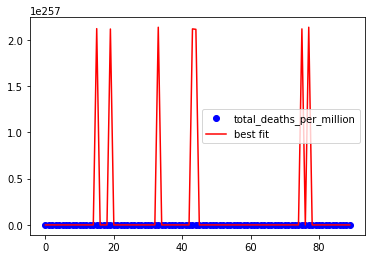

In [11]:
plt.plot(t, data_death, 'bo')
plt.plot(t, fit_model[4], 'r-', label='best fit')
plt.legend(loc='best')
plt.show()